## Visualization Module

In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from dateutil.tz import gettz
from typing import Any, Dict

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from constants import *
from data import CSVDataHandler

In [2]:
logging.basicConfig(level=logging.DEBUG,
                    format='[%(asctime)s %(levelname)-8s line %(lineno)s] %(funcName)15s: %(message)s',
                    datefmt='%a, %d %b %Y %H:%M:%S')

In [6]:
class StockTradingGraph():
    def __init__(self):
        self._bar_size = BAR_SIZE
        self._bar_narrow = BAR_SIZE_NARROW
        self._marker_size = MARKER_SIZE
        self._figsize = FIGURE_SIZE
        
    def _get_period(self, df:tpFrame, from_date:str = None, to_date:str = None) -> tpFrame:
        """
        Returns part of the DataFrame for a period [from_date, to_date]. 
        Takes into account possible situations, such as absence of date and so on.
        
        Parameters:
        df - original DataFrame
        from_date - starting date in YYYY-MM-DD format, e.g. '2018-04-07'
        to_date - ending date in YYYY-MM-DD format, e.g. '2018-06-22'
        
        Returns:
        Part of the original DataFrame
        """
        
        if from_date is None:
            from_date = df.index[0]
        else:
            # if from_date is not in index
            if from_date not in df.index:
                logging.debug("from date is %s" % from_date)
                d = dt.datetime.strptime(from_date, STD_DATE).replace(tzinfo=None) 
                logging.debug("comparison date is %s" % d)
                # if date is inside the period of the dataframe, but is a nontraded day
                if df.index[0] < d < df.index[-1]:
                    # get the next trading day
                    while d > df.index[0] and (d not in df.index): 
                        d = d - dt.timedelta(days = 1)
                    if d in df.index: from_date = d
                else: # from_date is out of range for the given data
                    logging.debug('No such from_date in data, show from the beginning')
                    from_date = df.index[0]    
        if to_date is None:
            to_date = df.index[-1]
        else:
            # same for the to_date
            if to_date not in df.index:
                d = dt.datetime.strptime(to_date, STD_DATE).replace(tzinfo=None)
                if df.index[0] < d < df.index[-1]:
                    while d < df.index[-1] and (d not in df.index): 
                        d = d + dt.timedelta(days = 1)
                    if d in df.index: to_date = d
                else: 
                    logging.debug('No such to_date in data, show up to the end')    
                    to_date = df.index[-1]
        return df[from_date:][:to_date]

    def _plot_preparation(self, noTime:bool, scale:bool, data_len:int = 0, 
                          title:str = 'Plot', xlabel:str = 'Date',
                          ylabel:str = 'Price', margins:float = 0.05):
        """
        Set up plot parameters.
        
        Parameters:
        noTime - if True, only dates are in data, no time
        scale - if True, scaling is needed, too much data available (>3 days)
        data_len - length of all data, used only if scale is True
        title, xlabel, ylabel, margins - standart plot parameters
        
        Returns:
        (fig, ax)
        """
        
        dtf = STD_DATE if noTime else STD_DATETIME
        formatter = mdates.DateFormatter(dtf)
        locator = mdates.HourLocator(byhour=range(0,24,2))
        if scale:
            if data_len == 0:
                logging.debug('Length of data is not given, thus scaling is not applicable')
            else:
                locator = mdates.DayLocator(bymonthday=range(1,32), 
                                            interval=max(25, data_len // 25)) 
        
        fig = plt.figure(figsize = self._figsize)
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)
        ax.margins(margins)
        
        return (fig, ax)
    
    def show_property(self, y:tpSeries, from_date:str = None, to_date:str = None,
                      title:str = 'Plot', xlabel:str = 'Date', ylabel:str = 'Price') -> None:
        """
        Shows any Series of data for the given dates.
        
        Parameters:
        y - Series of values
        from_date - starting date in YYYY-MM-DD format, e.g. '2018-04-07'
        to_date - ending date in YYYY-MM-DD format, e.g. '2018-06-22'
        title, xlabel, ylabel - standart plot parameters
        """
        
        y = self._get_period(y, from_date, to_date)            
        noTime = y.index[0].time() == dt.time(0)
        x = [d.date() for d in y.index] if noTime else y.index
        needScale = (x[-1] - x[0]) > dt.timedelta(days = 3)
        fig, ax = self._plot_preparation(noTime, needScale, len(x), title, xlabel, ylabel)
        ax.plot(x, y)
        fig.autofmt_xdate()
        plt.show()
        
    def _plot_trades(self, trades: tpFrame, tr_filter: tpSeries, exit:bool, 
                     marker:str, size:int = 0) -> None:
        """
        Plot trades with given markers
        
        Parameters:
        trades - Dataframe of trades for the given data
        tr_filter - Series for filtering trades (longs, shorts, and so on)
        exit - if True use exit_price for plotting, otherwise - entry_price
        marker - color and marker for plotting
        size - marker size
        """
        if size == 0:
            size = self._marker_size
            
        if not exit:
            df = trades.loc[tr_filter, ['entry_price']]
            plt.plot(df.index, df.entry_price, marker, markersize=size)
        else:
            df = trades.loc[tr_filter, ['exit_date', 'exit_price']]
            df.set_index('exit_date', inplace = True)
            plt.plot(df.index, df.exit_price, marker, markersize=size)
            
    
    def show_ticker(self, df:tpFrame, trades:tpFrame = None, 
                    from_date:str = None, to_date:str = None,
                    title:str = 'Plot', xlabel:str = 'Date', ylabel:str = 'Price') -> None:
        """
        Plot bars from dataframe, and trades if given.
        
        Parameters:
        df - Dataframe of bars (OHLC)
        trades - Dataframe of trades for the given data
        from_date - starting date in YYYY-MM-DD format, e.g. '2018-04-07'
        to_date - ending date in YYYY-MM-DD format, e.g. '2018-06-22'
        title, xlabel, ylabel - standart plot parameters
        """
        
        df = self._get_period(df, from_date, to_date)
        noTime = (df.index[0].time() == dt.time(0))
        needScale = (df.index[-1] - df.index[0]) > dt.timedelta(days = 3)
        fig, ax = self._plot_preparation(noTime, needScale, len(df.index), title, xlabel, ylabel)
        
        # plot bars
        palette = ['r' if o > c else 'g' for (o,c) in df[['open','close']].values]
        plt.vlines(df.index, df.open, df.close, colors=palette, linestyles='solid', linewidth = self._bar_size)
        plt.vlines(df.index, df.low, df.high, colors=palette, linestyles='solid', linewidth = self._bar_narrow)
        
        # plot trades
        if trades is not None:
            trades = trades[df.index[0]:df.index[-1]]
            self._plot_trades(trades, trades.position == 'LONG', False, 'k^')
            self._plot_trades(trades, trades.position == 'SHORT', False, 'kv')
            self._plot_trades(trades, (trades.position == 'LONG') & (trades['profit, $'] > 0), True, 'gv')
            self._plot_trades(trades, (trades.position == 'LONG') & (trades['profit, $'] <= 0), True, 'rv')
            self._plot_trades(trades, (trades.position == 'SHORT') & (trades['profit, $'] > 0), True, 'g^')
            self._plot_trades(trades, (trades.position == 'SHORT') & (trades['profit, $'] <= 0), True, 'g^')
        
        fig.autofmt_xdate()
        plt.show()

In [7]:
bars = CSVDataHandler('data', TIMEFRAME_DAY,
                      {'UVXY':
                       {'src': 'av', 'tz': 'US/Eastern', 'exn':True, 'file':'UVXY_daily.csv'}, 
                       'IMOEX':
                       {'src': 'finam', 'tz': 'Europe/Moscow'}
                      })

In [8]:
df = bars.all_bars('IMOEX')
df.head()

,open,high,low,close,volume
datetime,,,,,
2000-01-05,173.00,173.00,173.00,173.00,0.0
2000-01-06,186.26,186.26,186.26,186.26,0.0
2000-01-10,200.81,200.81,200.81,200.81,0.0
2000-01-11,199.57,199.57,199.57,199.57,0.0
2000-01-12,196.88,196.88,196.88,196.88,0.0


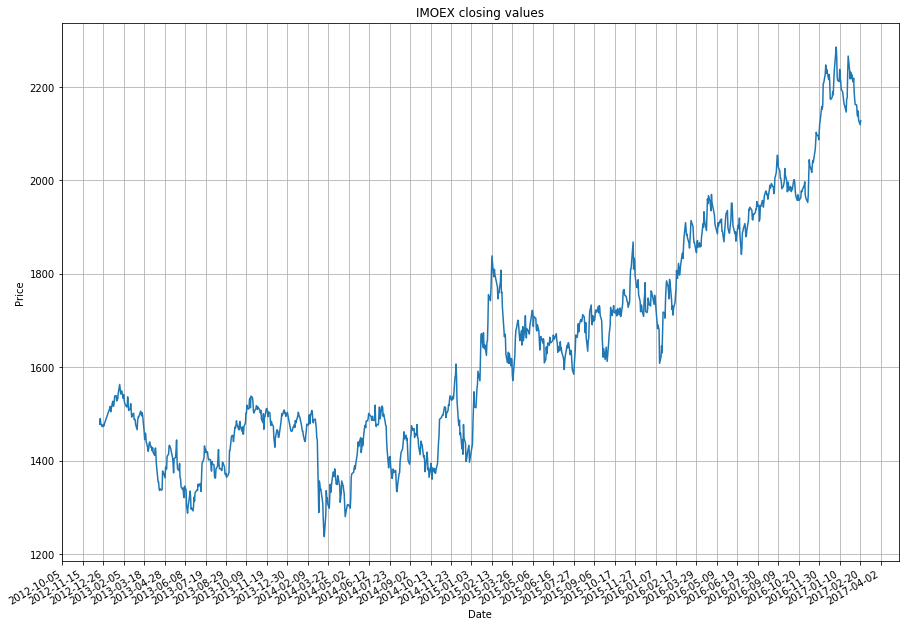

In [10]:
visualizer = StockTradingGraph()
visualizer.show_property(df.close, from_date = '2012-12-19', to_date = '2017-02-21', title = 'IMOEX closing values')

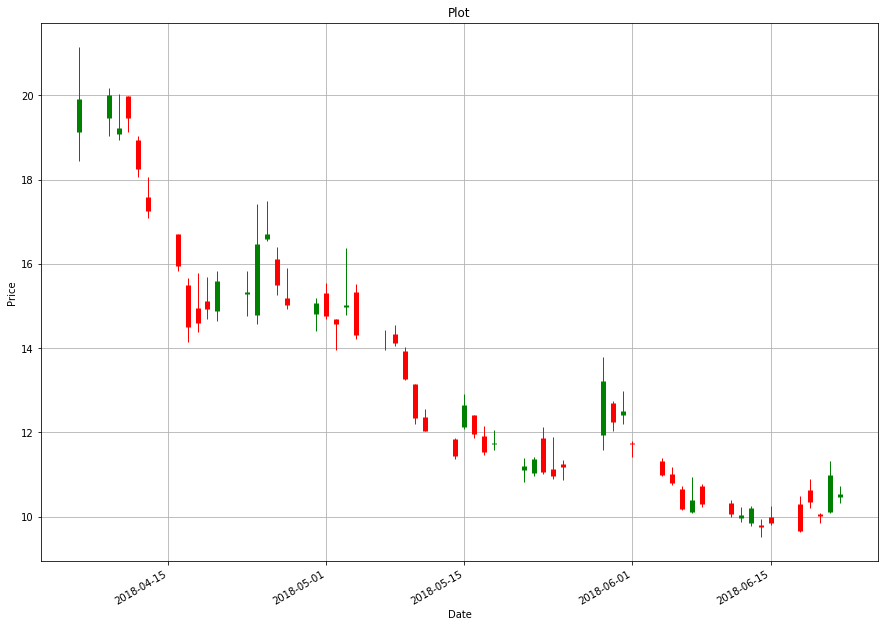

In [70]:
visualizer = StockTradingGraph()
visualizer.show_ticker(df, from_date = '2018-04-07', to_date = '2018-06-22')